# Отток клиентов
**Описание**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
[Источник данных](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

Признаки:
- RowNumber – индекс строки в данных
- CustomerId – уникальный идентификатор клиента
- Surname – фамилия
- CreditScore – кредитный скоринг
- Geography – страна проживания
- Gender – пол
- Age – возраст
- Tenure – количество недвижимости у клиента
- Balance – баланс на счете
- NumOfProducts – количество продуктов банка, используемых клиентом
- HasCrCard – наличие кредитной карты
- IsActiveMember – активность клиента
- EstimatedSalary – предполагаемая зарплата

Целевой признак:
- Exited – факт ухода клиента

In [38]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample

**Загрузка и предобработка данных**

In [39]:
# Загружаем данные
data = pd.read_csv('Churn_Modelling.csv')

# Удаляем нерелевантные фичи
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Формируем столбец с целевой переменной
y = data['Exited']

# Формируем таблицу признаков (Отбрасываем целевую переменную)
X = data.drop(columns=['Exited'])

# Делим данные на тренировочную и тестовую части в соотношении 70/30%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем отдельные кортежи с названиями признаков для категориальных и непрерывных фичей
columns_continuous = ('CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary')
columns_categorical = ('Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember')

# Создаем список с трансформерами для переменных
# Для категориальных переменных: OneHotEncoder()
# Для непрерывных переменных: StandardScaler()
column_tuples = [ ([column], OneHotEncoder()) for column in columns_categorical]
column_tuples = column_tuples + [([column], StandardScaler()) for column in columns_continuous]

# Создаем объект DataFrameMapper для трансформации признаков
mapper = DataFrameMapper(column_tuples, df_out=True)

# Обучаем mapper на тренировочных данных и
# трансформируем тренировочную и тестовую выборки
x_train_processed = mapper.fit_transform(x_train)
x_test_processed = mapper.transform(x_test)

**Построение логистической регрессии**

In [40]:
# Проводим кросс-валидацию для модели логистической регрессии,
# находим наилучший коэффициент регуляризации и обучаем лучшую модель
model = GridSearchCV(
    LogisticRegression(random_state=0),
    param_grid={'C': np.arange(0.001, 0.01, 0.001)},
    scoring='roc_auc',
    cv=4,
    verbose=0)
model.fit(x_train_processed, y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=0),
             param_grid={'C': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])},
             scoring='roc_auc')

In [41]:
# Предсказываем значения для тренировочного и тестового датасета
y_pred_train = model.decision_function(x_train_processed)
y_pred_test = model.decision_function(x_test_processed)

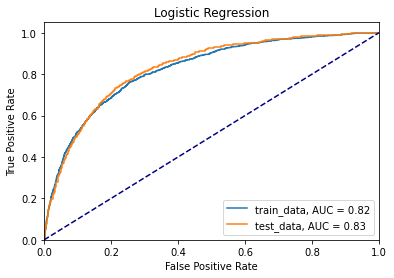

In [42]:
# Рассчитываем AUC
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Строим ROC-кривые
plt.plot(fpr_train, tpr_train,
         label='train_data, AUC = %0.2f' % auc_train)
plt.plot(fpr_test, tpr_test,
         label='test_data, AUC = %0.2f' % auc_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [53]:
# Выводим параметры для лучшей модели
model.best_estimator_

LogisticRegression(C=0.009000000000000001, random_state=0)

Далее рассчитаем, является ли полученная модель статистически значимой. Для этого выберем порог значимости alpha = 5%. Чтобы понять, является ли модель статистически значимой, необходимо сравнить P-value с порогом alpha.

In [49]:
# Рассчитываем статистическую значимость модели логистической регрессии с лучшим коэффициентом регуляризации

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

score, perm_scores, pvalue = permutation_test_score(
    model.best_estimator_, x_train_processed, y_train,
    scoring="roc_auc", cv=cv, n_permutations=1000, n_jobs=-1)

print('Best Score: {}'.format(model.best_score_))
print('P-value: {}'.format(pvalue))

Best Score: 0.8202885969598368
P-value: 0.000999000999000999


P-value показывает вероятность того, что Score модели обусловлен случайностью. Так как P-value < alpha ( 0.1% < 5% ), то можно утверждать, что полученное значение Score не является случайностью, а обусловлено правильным подбором параметров модели.

**Применение градиентного бустинга**

In [44]:
# Проводим кросс-валидацию, находим наилучшие значения гиперпараметров и обучаем лучшую модель
model_boost = GridSearchCV(
    GradientBoostingClassifier(random_state=0, min_samples_split=0.1,
                               min_samples_leaf=0.1, subsample=0.9),
    param_grid={'n_estimators': np.arange(10, 200, 10),
                'learning_rate': np.arange(0.1, 0.5, 0.1),
                'max_depth': np.arange(10, 25, 5),
                'max_features': np.arange(1, 8, 1)},
    scoring='roc_auc',
    cv=4,
    n_jobs=-1)
model_boost.fit(x_train_processed, y_train)

GridSearchCV(cv=4,
             estimator=GradientBoostingClassifier(min_samples_leaf=0.1,
                                                  min_samples_split=0.1,
                                                  random_state=0,
                                                  subsample=0.9),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                         'max_depth': array([10, 15, 20]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
             scoring='roc_auc')

In [45]:
# Предсказываем значения для тренировочной и тестовой выборки
y_pred_train_boost = model_boost.decision_function(x_train_processed)
y_pred_test_boost = model_boost.decision_function(x_test_processed)

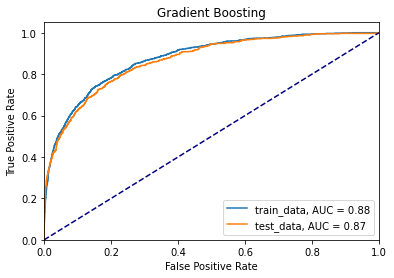

In [46]:
# Рассчитываем AUC
fpr_train_boost, tpr_train_boost, thresholds_train = roc_curve(y_train, y_pred_train_boost)
fpr_test_boost, tpr_test_boost, thresholds_test = roc_curve(y_test, y_pred_test_boost)
auc_train_boost = auc(fpr_train_boost, tpr_train_boost)
auc_test_boost = auc(fpr_test_boost, tpr_test_boost)

# Строим ROC-кривые
plt.plot(fpr_train_boost, tpr_train_boost,
         label='train_data, AUC = %0.2f' % auc_train_boost)
plt.plot(fpr_test_boost, tpr_test_boost,
         label='test_data, AUC = %0.2f' % auc_test_boost)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

In [47]:
# Выводим параметры для лучшей модели
model_boost.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=10, max_features=7,
                           min_samples_leaf=0.1, min_samples_split=0.1,
                           n_estimators=130, random_state=0, subsample=0.9)

In [54]:
score_boost, perm_scores_boost, pvalue_boost = permutation_test_score(
    model_boost.best_estimator_, x_train_processed, y_train,
    scoring="roc_auc", cv=cv, n_permutations=1000, n_jobs=-1)

print('Best Score: {}'.format(model_boost.best_score_))
print('P-value: {}'.format(pvalue_boost))

Best Score: 0.8511945955352662
P-value: 0.000999000999000999


Полученное значение P-value также меньше порога alpha, поэтому результат данной модели определен не случайностью, а правильно подобранными параметрами модели.

**Заключение**

Для предсказания ухода клиентов была проведена предобработка данных, включающая удаление нерелевантных признаков, стандартизацию непрерывных и кодирование категориальных признаков. Данные были разделены на тренировочную (70%) и тестовую (30%) части. Далее были построены модели логистической регрессии и градиентного бустинга над решающими деревьями. Для определения гиперпараметров моделей использовалась кросс-валидация по сетке значений гиперпараметров. Наилучшие значения гиперпараметров определялись путем максимизации метрики AUC.

Расчет P-значения показал, что обе модели являются статистически значимыми (полученные значения метрики AUC обусловлены правильным подбором гиперпараметров моделей, а не случайностью).

Наилучшей моделью оказалась модель градиентного бустинга с параметрами (learning_rate=0.2, max_depth=10, max_features=7, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=130, random_state=0, subsample=0.9). Значение AUC, полученное при помощи данной модели, составило 0.88 для тренировочной и 0.87 для тестовой выборки.